In [1]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import torch
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from data_utility import *
from data_utils import *
from loss import *
from train import *
from deeplab_model.deeplab import *
from sync_batchnorm import convert_model
import datetime

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
USE_GPU = True
NUM_WORKERS = 12
BATCH_SIZE = 2 

dtype = torch.float32 
# define dtype, float is space efficient than double

if USE_GPU and torch.cuda.is_available():
    
    device = torch.device('cuda')
    
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    # magic flag that accelerate
    
    print('using GPU for training')
else:
    device = torch.device('cpu')
    print('using CPU for training')

using GPU for training


In [3]:
train_dataset = pyramid_dataset(data_type = 'nii_train', 
                transform=transforms.Compose([
                random_affine(90, 15),
                random_filp(0.5)]))
# do data augumentation on train dataset

validation_dataset = pyramid_dataset(data_type = 'nii_test', 
                transform=None)
# no data augumentation on validation dataset

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                    num_workers=NUM_WORKERS)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True,
                    num_workers=NUM_WORKERS) # drop_last
# loaders come with auto batch division and multi-thread acceleration

In [4]:
"""
deeplab = DeepLab(output_stride=16)
deeplab = nn.DataParallel(deeplab)
deeplab = convert_model(deeplab)
deeplab = deeplab.to(device=device, dtype=dtype)
#shape_test(icnet1, True)
# create the model, by default model type is float, use model.double(), model.float() to convert
# move the model to desirable device

optimizer = optim.Adam(deeplab.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
epoch = 0

# create an optimizer object
# note that only the model_2 params and model_4 params will be optimized by optimizer
"""

"\ndeeplab = DeepLab(output_stride=16)\ndeeplab = nn.DataParallel(deeplab)\ndeeplab = convert_model(deeplab)\ndeeplab = deeplab.to(device=device, dtype=dtype)\n#shape_test(icnet1, True)\n# create the model, by default model type is float, use model.double(), model.float() to convert\n# move the model to desirable device\n\noptimizer = optim.Adam(deeplab.parameters(), lr=1e-2)\nscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)\nepoch = 0\n\n# create an optimizer object\n# note that only the model_2 params and model_4 params will be optimized by optimizer\n"

In [5]:
deeplab = DeepLab(output_stride=16)
deeplab = nn.DataParallel(deeplab)
deeplab = convert_model(deeplab)

#checkpoint = torch.load('../deeplab_save/2019-07-29 00:44:11.825872.pth')
#checkpoint = torch.load('../deeplab_dilated_save/2019-08-01 08:57:17.225282.pth') # best one
#checkpoint = torch.load('../deeplab_dilated_save/2019-08-08 18:16:47.245901 epoch: 960.pth') # latest one
#checkpoint = torch.load('../deeplab_save/2019-07-29 00:15:49.271222.pth')
checkpoint = torch.load('../deeplab_dilated_save/2019-08-10 09:28:43.844872 epoch: 1160.pth')

deeplab.load_state_dict(checkpoint['state_dict_1'])
deeplab = deeplab.to(device, dtype)

optimizer = optim.Adam(deeplab.parameters(), lr=1e-2)
optimizer.load_state_dict(checkpoint['optimizer'])
#scheduler.load_state_dict(checkpoint['scheduler'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1)
#scheduler.load_state_dict(checkpoint['scheduler'])

epoch = checkpoint['epoch']
print(epoch)


1160


In [ ]:
epochs = 5000

record= open('train_deeplab_least_dilation.txt','a')

logger = {'train':[], 'validation_1': []}

min_val = 0.0643

for e in tqdm(range(epoch + 1, epochs)):
# iter over epoches

    epoch_loss = 0
        
    for t, batch in enumerate(train_loader):
    # iter over the train mini batches
    
        deeplab.train()
        # Set the model flag to train
        # 1. enable dropout
        # 2. batchnorm behave differently in train and test
        
        image_1 = batch['image1_data'].to(device=device, dtype=dtype)
        label_1 = batch['image1_label'].to(device=device, dtype=dtype)
        # move data to device, convert dtype to desirable dtype
        
        out_1 = deeplab(image_1)
        # do the inference

        loss_1 = dice_loss_3(out_1, label_1)
        # calculate loss
        
        epoch_loss += loss_1.item()
        # record minibatch loss to epoch loss
        
        optimizer.zero_grad()
        # set the model parameter gradient to zero
        
        loss_1.backward()
        # calculate the gradient wrt loss
        optimizer.step()
        #scheduler.step(loss_1)
        # take a gradient descent step
        
    outstr = 'Epoch {0} finished ! Training Loss: {1:.4f}'.format(e, epoch_loss/(t+1)) + '\n'
    
    logger['train'].append(epoch_loss/(t+1))
    
    print(outstr)
    record.write(outstr)
    record.flush()

    if e%5 == 4:
    # do validation every 5 epoches
    
        deeplab.eval()
        # set model flag to eval
        # 1. disable dropout
        # 2. batchnorm behave differs

        with torch.no_grad():
        # stop taking gradient
        
            #valloss_4 = 0
            #valloss_2 = 0
            valloss_1 = 0
            
            for v, vbatch in enumerate(validation_loader):
            # iter over validation mini batches
                
                image_1_val = vbatch['image1_data'].to(device=device, dtype=dtype)
                if get_dimensions(image_1_val) == 4:
                    image_1_val.unsqueeze_(0)
                label_1_val = vbatch['image1_label'].to(device=device, dtype=dtype)
                if get_dimensions(label_1_val) == 4:
                    label_1_val.unsqueeze_(0)
                # move data to device, convert dtype to desirable dtype
                # add one dimension to labels if they are 4D tensors
                
                out_1_val = deeplab(image_1_val)
                # do the inference
                
                loss_1 = dice_loss_3(out_1_val, label_1_val)
                # calculate loss

                valloss_1 += loss_1.item()
                # record mini batch loss
            avg_val_loss = (valloss_1/(v+1))
            outstr = '------- 1st valloss={0:.4f}'\
                .format(avg_val_loss) + '\n'
            
            logger['validation_1'].append(avg_val_loss)
            scheduler.step(avg_val_loss)
            
            print(outstr)
            record.write(outstr)
            record.flush()
            
            if avg_val_loss < min_val:
                print(avg_val_loss, ' <', min_val)
                min_val = avg_val_loss
            
            save_1('deeplab_dilated_save', deeplab, optimizer, logger, e, scheduler)

record.close()

1it [00:32, 32.42s/it]

0.003953099250793457 0.07919526100158691 0.12891554832458496 0.07068797200918198


2it [00:34, 23.21s/it]

0.003556489944458008 0.07576048374176025 0.14427030086517334 0.07452909648418427


3it [00:36, 16.83s/it]

0.0037217140197753906 0.06503379344940186 0.14999735355377197 0.0729176253080368


4it [00:37, 12.32s/it]

0.0025670528411865234 0.09891557693481445 0.11511838436126709 0.07220034301280975


5it [00:39,  9.20s/it]

0.0034122467041015625 0.06661128997802734 0.12042486667633057 0.06348280608654022


6it [00:41,  6.98s/it]

0.003925204277038574 0.0683060884475708 0.1588507890701294 0.07702736556529999


7it [00:43,  5.47s/it]

0.003076910972595215 0.08632838726043701 0.11075913906097412 0.06672148406505585


8it [00:45,  4.36s/it]

0.004375457763671875 0.05446219444274902 0.14913082122802734 0.06932282447814941


9it [00:47,  3.63s/it]

0.004435300827026367 0.07442784309387207 0.12250423431396484 0.0671224594116211
0.004260361194610596 0.10160225629806519 0.09734052419662476 0.06773438304662704


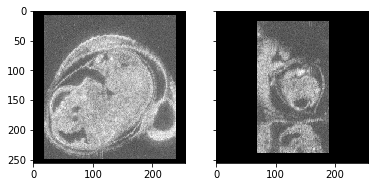

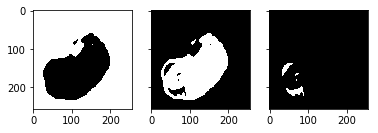

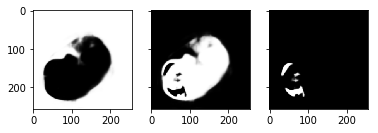

11it [00:52,  3.00s/it]

0.0045424699783325195 0.06159615516662598 0.1347130537033081 0.06695055961608887


12it [00:54,  2.64s/it]

0.0033440589904785156 0.08327484130859375 0.13149017095565796 0.07270302623510361


13it [00:55,  2.43s/it]

0.003804802894592285 0.09170997142791748 0.14340907335281372 0.07964128255844116


14it [00:57,  2.24s/it]

0.003929018974304199 0.06774282455444336 0.15441763401031494 0.0753631591796875


15it [00:59,  2.16s/it]

0.0046651363372802734 0.06658005714416504 0.1176990270614624 0.06298141181468964


16it [01:01,  2.06s/it]

0.004984438419342041 0.06349515914916992 0.1454075574874878 0.07129572331905365
0.0029717683792114258 0.05771207809448242 0.2841365933418274 0.11494015157222748


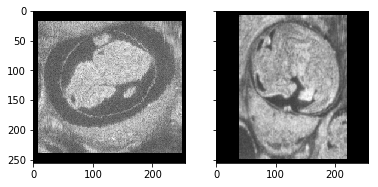

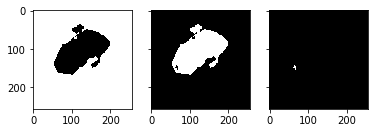

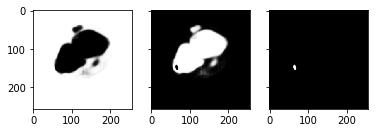

18it [01:06,  2.22s/it]

0.0028183460235595703 0.09824931621551514 0.09938645362854004 0.06681804358959198


19it [01:08,  2.13s/it]

0.0032976269721984863 0.06340110301971436 0.1338750123977661 0.06685791909694672


20it [01:10,  2.03s/it]

0.003161787986755371 0.06960928440093994 0.11135554313659668 0.061375539749860764


21it [01:12,  2.01s/it]

0.003811657428741455 0.06952667236328125 0.11456102132797241 0.06263311952352524


22it [01:14,  1.94s/it]

0.002975761890411377 0.07817292213439941 0.15053224563598633 0.07722698152065277


23it [01:15,  1.94s/it]

0.0025478601455688477 0.07531177997589111 0.13460195064544678 0.07082053273916245
------- background loss = 0.0037, body loss = 0.0747, bv loss = 0.1371



In [6]:
deeplab.eval()

with torch.no_grad():
    
    bgloss = 0
    bdloss = 0
    bvloss = 0
    
    for v, vbatch in tqdm(enumerate(validation_loader)):
            # move data to device, convert dtype to desirable dtype

        image_1 = vbatch['image1_data'].to(device=device, dtype=dtype)
        label_1 = vbatch['image1_label'].to(device=device, dtype=dtype)

        output = deeplab(image_1)
        # do the inference
        output_numpy = output.cpu().numpy()
        
        
        #out_1 = torch.round(output)
        out_1 = torch.from_numpy((output_numpy == output_numpy.max(axis=1)[:, None]).astype(int)).to(device=device, dtype=dtype)
        loss_1 = dice_loss_3(out_1, label_1)

        bg, bd, bv = dice_loss_3_debug(out_1, label_1)
        # calculate loss
        print(bg.item(), bd.item(), bv.item(), loss_1.item())
        bgloss += bg.item()
        bdloss += bd.item()
        bvloss += bv.item()
        
        if bv.item() >= 0.2 or bd.item() >= 0.1:
            show_image_slice(image_1)
            show_image_slice(label_1)
            show_image_slice(output)

    outstr = '------- background loss = {0:.4f}, body loss = {1:.4f}, bv loss = {2:.4f}'\
        .format(bgloss/(v+1), bdloss/(v+1), bvloss/(v+1)) + '\n'
    
    #print(bdloss, v)
    print(outstr)